In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shap
import pandas as pd
import yaml
from typing import Literal

from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif, mutual_info_regression
from sklearn.kernel_ridge import KernelRidge

In [2]:
import os
from pathlib import Path

# Go up one directory level from the notebook's location
project_root = Path().resolve().parent  # Navigate to the parent directory
os.chdir(project_root)  # Set this as the working directory

# print("Current working directory set to:", os.getcwd())

In [3]:
# Fixed parameters
NUM_CLF_LABELS = 11
NUM_RGR_LABELS = 4

In [4]:
with open('config/paths.yaml', 'r') as file:
    paths = yaml.load(file, Loader=yaml.FullLoader)

with open('config/params.yaml', 'r') as file:
    params = yaml.load(file, Loader=yaml.FullLoader)

# Load the data
X = pd.read_csv(paths["train"]["final_features"])
y = pd.read_csv(paths["train"]["labels"])
test_X = pd.read_csv(paths["test"]["final_features"])

print(f"Number of Features: {len(X.columns)}")
print(f"Number of Labels: {len(y.columns)}")

Number of Features: 172
Number of Labels: 16


In [5]:
clf_model = params["clf_model"]
regr_model = params["regr_model"]

clf_params = params[clf_model]
regr_params = params[regr_model]

clf_model_class = eval(clf_model)
regr_model_class = eval(regr_model)

# Instantiate the model
clf_model = clf_model_class(**clf_params)
regr_model = regr_model_class(**regr_params)

print(clf_model)
print(regr_model)

RandomForestClassifier(class_weight='balanced', max_depth=32,
                       min_samples_leaf=16, n_estimators=200)
KernelRidge(alpha=1.0, gamma=0.01, kernel='rbf')


### **Feature Selection: Importance and Implementation**

#### **Why Feature Selection?**
Feature selection enhances model performance by focusing on the most relevant features, reducing noise, improving interpretability, and speeding up computation. It helps prevent overfitting and ensures models generalize better to unseen data.

#### **Implementation**
1. **`feature_selection`**:
   - Uses cross-validation with a feature selector (e.g., `SelectFromModel`) and a predictive model to identify important features for inference.
   - The feature selector ranks features based on a scoring criterion and selects at most \( k \) features that correspond to the highest model score achieved during cross-validation on the training data.
   - Returns the indices of the selected features


2. **`create_feature_mask`**:
   - Applies `feature_selection` individually for each label in a multi-label dataset.
   - Generates a boolean mask indicating which features are selected for each label.

This approach ensures robust, label-specific feature selection optimized for predictive performance.


In [6]:
def feature_selection(X, y, selector, model_class, model_params, splitter):
    """
    Performs feature selection using Stratified K-Fold cross-validation and
    returns the indices of the selected features.

    Parameters:
    - X: pd.DataFrame, input features
    - y: pd.Series, target labels
    - selector: feature selector (e.g., SelectFromModel, SelectKBest)
    - model: sklearn model to train (e.g., LogisticRegression, RandomForestClassifier)
    - model_params: dict, hyperparameters for the model
    - splitter: sklearn splitter (e.g., StratifiedKFold, KFold)

    Returns:
    # - X_selected: pd.DataFrame, input features with selected features
    - selected_indices: list, indices of the selected features
    """

    cv_splits = splitter.split(X, y)

    cv_scores = []
    best_selector = None

    for train_idx, val_idx in cv_splits:
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Fit the selector on the training data
        selector.fit(X_train, y_train)

        X_train_selected = selector.transform(X_train)
        X_val_selected = selector.transform(X_val)

        # Recreate the model (reset it) each time in the loop
        if model_params is None:
            model = model_class()  # Create model without parameters
        else:
            model = model_class(**model_params)  # Create model with parameters

        # Fit the model on the selected features
        model.fit(X_train_selected, y_train)

        # Evaluate the model on the validation data
        score = model.score(X_val_selected, y_val)
        cv_scores.append(score)

        # Keep track of the selector that gives the best score
        if best_selector is None or score > max(cv_scores):
            best_selector = selector

    # Get the selected features based on the best selector
    selected_indices = best_selector.get_support(indices=True)
    # X_selected = best_selector.transform(X)

    return selected_indices, max(cv_scores)


def create_feature_mask(
    X, y, k_values, selector, model_class, model_params, splitter, out_file=None
):
    """
    Creates a mask of the selected features.

    Parameters:
    - X: pd.DataFrame, input features
    - y: pd.DataFrame, target labels
    - k_values: list, values of k to use for selector
    - selector: feature selector (e.g., SelectFromModel, SelectKBest)
    - model: sklearn model to train (e.g., LogisticRegression, RandomForestClassifier)
    - model_params: dict, hyperparameters for the model
    - splitter: sklearn splitter (e.g., StratifiedKFold, KFold)
    - out_file: str, path to save the mask

    Returns:
    - mask: pd.DataFrame, boolean mask of the selected features
    """

    # Initialize the mask DataFrame with all False (no feature selected)
    mask_df = pd.DataFrame(False, index=y.columns, columns=X.columns)
    mask_df.index.name = "label"

    all_scores = {}

    for label in y.columns:

        best_indices = None
        best_score = -np.inf
        label_scores = {}

        for k in k_values:

            # Initialize the selector with the current k
            if isinstance(selector, SelectKBest):
                selector.set_params(k=k)
            elif isinstance(selector, SelectFromModel):
                selector.set_params(max_features=k)
            else:
                raise ValueError("Invalid selector")

            # Perform feature selection for this label and k
            selected_indices, k_score = feature_selection(
                X=X,
                y=y[label],
                selector=selector,
                model_class=model_class,
                model_params=model_params,
                splitter=splitter,
            )

            label_scores[k] = k_score

            if k_score > best_score:
                best_indices = selected_indices
                best_score = k_score

        all_scores[label] = label_scores
        mask_df.loc[label, X.columns[best_indices]] = True

    if out_file is not None:
        mask_df.to_csv(out_file, index=True)

    return all_scores, mask_df

In [7]:
clf_mask_file = paths["clf_mask_file"]
regr_mask_file = paths["regr_mask_file"]

# clf_mask_file = "data/debug/clf_mask.csv"
# regr_mask_file = "data/debug/regr_mask.csv"


print("Classifier mask file:", clf_mask_file)
print("Regressor mask file:", regr_mask_file)

# For testing purposes
# X = X.iloc[:1000, :]
# y = y.iloc[:1000, :]

# Remove the 'pid' column from the features and labels
X.drop(columns='pid', inplace=True)
y.drop(columns='pid', inplace=True)

y_clf = y.iloc[:, :NUM_CLF_LABELS]
y_regr = y.iloc[:, NUM_CLF_LABELS:]

Classifier mask file: data/processed/clf_feature_mask.csv
Regressor mask file: data/processed/regr_feature_mask.csv


In [13]:
# Hyperparameters
SEED = 42
N_SPLITS = 5 # Number of splits for cross-validation during feature selection

CLF_FEATURES = [20, 30, 40, 50]
REGR_FEATURES = [30, 40]

In [9]:
# Create a mask of the selected features for the classifiers
clf_splitter = StratifiedKFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)
clf_selector = SelectFromModel(clf_model)
# clf_selector = SelectKBest(f_classif)
clf_fs_scores, clf_mask = create_feature_mask(
    X=X,
    y=y_clf,
    k_values=CLF_FEATURES,
    selector=clf_selector,
    model_class=clf_model_class,
    model_params=clf_params,
    splitter=clf_splitter,
    out_file=clf_mask_file,
)

In [10]:
clf_fs_scores

{'LABEL_BaseExcess': {20: 0.865490918662806,
  30: 0.8660173729928928,
  40: 0.8665438273229797,
  50: 0.8681231903132404},
 'LABEL_Fibrinogen': {20: 0.8997104501184522,
  30: 0.9055014477494078,
  40: 0.9073440379047117,
  50: 0.9110292182153198},
 'LABEL_AST': {20: 0.7417741510923928,
  30: 0.7465122400631745,
  40: 0.7562516451697815,
  50: 0.756514872334825},
 'LABEL_Alkalinephos': {20: 0.7541458278494341,
  30: 0.7567780994998684,
  40: 0.7615161884706502,
  50: 0.7717820479073441},
 'LABEL_Bilirubin_total': {20: 0.7372992892866543,
  30: 0.7483548302184786,
  40: 0.7541458278494341,
  50: 0.7557251908396947},
 'LABEL_Lactate': {20: 0.8036325348775993,
  30: 0.8083706238483811,
  40: 0.8094235325085549,
  50: 0.8128454856541195},
 'LABEL_TroponinI': {20: 0.910502763885233,
  30: 0.9162937615161885,
  40: 0.9168202158462754,
  50: 0.9168202158462754},
 'LABEL_SaO2': {20: 0.8017899447222954,
  30: 0.8096867596735983,
  40: 0.8125822584890761,
  50: 0.8136351671492498},
 'LABEL_Bilir

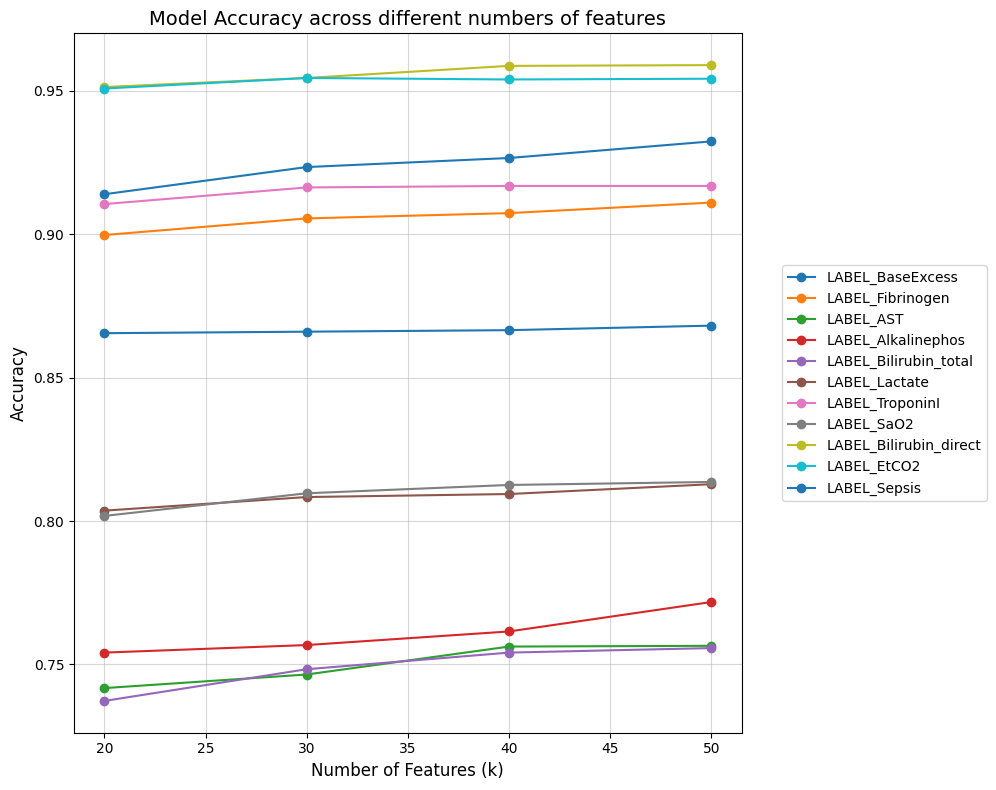

In [11]:
# Extract X values (number of features)
x_values = list(next(iter(clf_fs_scores.values())).keys())

# Create the plot
plt.figure(figsize=(12, 8))

for label, scores in clf_fs_scores.items():
    plt.plot(x_values, list(scores.values()), marker="o", label=label)

# Add labels, title, and legend
plt.xlabel("Number of Features (k)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Accuracy across different numbers of features", fontsize=14)

# Place legend outside the plot on the right
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=10)
plt.grid(alpha=0.5)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area

# Show plot
plt.show()

In [14]:
# Create a mask of the selected features for the regressors
regr_splitter = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)
regr_selector = SelectKBest(mutual_info_regression)
regr_fs_scores, regr_mask = create_feature_mask(
    X=X,
    y=y_regr,
    k_values=REGR_FEATURES,
    selector=regr_selector,
    model_class=regr_model_class,
    model_params=regr_params,
    splitter=regr_splitter,
    out_file=regr_mask_file,
)

In [15]:
regr_fs_scores

{'LABEL_RRate': {30: -8.54176056512267, 40: -17.003024291004564},
 'LABEL_ABPm': {30: -24.797035958281853, 40: -31.033340057001716},
 'LABEL_SpO2': {30: -406.7170839896983, 40: -766.6200249730057},
 'LABEL_Heartrate': {30: -7.246858834628387, 40: -13.695500512928568}}

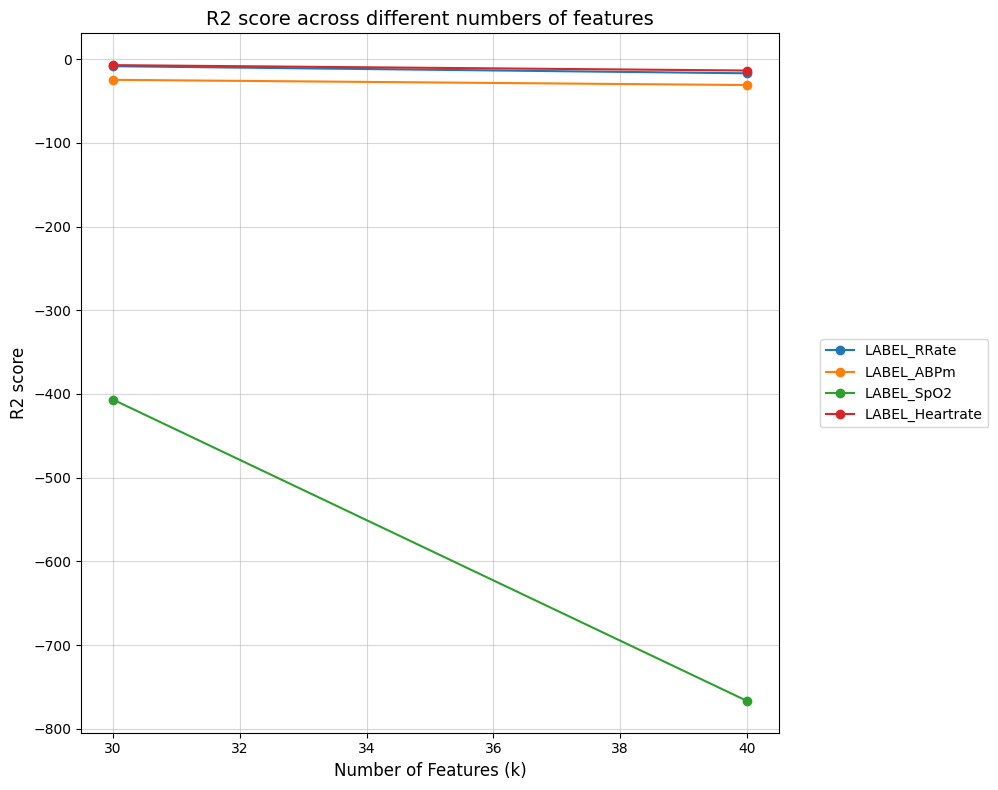

In [16]:
# Extract X values (number of features)
x_values = list(next(iter(regr_fs_scores.values())).keys())

# Create the plot
plt.figure(figsize=(12, 8))

for label, scores in regr_fs_scores.items():
    plt.plot(x_values, list(scores.values()), marker="o", label=label)

# Add labels, title, and legend
plt.xlabel("Number of Features (k)", fontsize=12)
plt.ylabel("R2 score", fontsize=12)
plt.title("R2 score across different numbers of features", fontsize=14)

# Place legend outside the plot on the right
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=10)
plt.grid(alpha=0.5)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area

# Show plot